# European Football Odds Analysis
> Checking out Soccer/Football odds

- toc: false
- badges: true
- comments: true
- categories: [soccer, benchmark, webscraping, brier, accuracy, calibration]

I've started thinking about applying machine learning to betting the European Soccer Leagues. It seems like it's going to be a little bit different of a problem, as there are 3 possible outcomes for every match (win, lose, draw). But still, I'd like to see if the profitablemachine learning process I put together for American Baseball will hold.  

The first step in this process is getting data on how well the oddsmakers can predict the outcomes of these matches. I know that covers.com is pretty easy to scrape data from, and they aggregate the published odds from several sites. So let's see how well they predict match outcomes.

**Each blog post on this site, including this one, is executable. Use the buttons at the top to run the code on Binder of Colab and get fresh results for yourself.** You can also download it from Github to run the notebook locally.

## Scraping Data from Covers.com
> Important: Web scraping is dependant on other people's web pages. If they change their site, this blog's code will break. Don't expect the code presented here to work forever.


Below will download odds data for each of the big 5 European leagues from [covers.com](http://covers.com).

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_covers_data(day):
    # day as datetime object
    date = day.strftime("%Y-%m-%d")
    leagues = ['premier-league','la-liga', 'lig1', 'bund','ita']
    data = []
    for league in leagues:
        # prep url and get the page
        url = f'https://www.covers.com/sports/{league}/matchups?selectedDate={date}'
        html = requests.get(url).text
        soup = bs(html,'lxml')

        # check to make sure the date on the page is the same date we want
        page_date = soup.find('a', {"class": 'cmg_active_navigation_item'})['data-date']
        if page_date!=date: continue

        # parse the html
        matchups = soup.findAll('div',{'class':'covers-CoversWorldCup-matchupBlock'})
        for m in matchups:
            d = {}
            try:
                d['league'] = league
                d['date'] = date
                matchup_titles = m.find('span', {'id':'covers-CoversWorldCup-matchup-title'}).text.split('@')
                d['away_team_name'] = matchup_titles[0]
                d['home_team_name'] = matchup_titles[1]
                d['away_team_short_name'] = m.find('div',{'class':'covers-CoversWorldCup-leftFeatureName'}).text.strip()
                d['away_team_odds'] = m.find('div',{'class':'covers-CoversWorldCup-leftFeatureLine'}).text.strip()
                d['draw_odds'] = m.find('div',{'class':'covers-CoversWorldCup-drawOdds'}).text[5:].strip()
                d['home_team_short_name'] = m.find('div',{'class':'covers-CoversWorldCup-rightFeatureName'}).text.strip()
                d['home_team_odds'] = m.find('div',{'class':'covers-CoversWorldCup-rightFeatureLine'}).text.strip()
                try:
                    scores = m.find('div',{'class':'covers-CoversWorldCup-timeTag covers-CoversWorldCup-timeTag-inGame'}).findAll('b')
                    d['away_team_score'] = scores[0].text
                    d['home_team_score'] = scores[1].text
                except:
                    # no scores
                    pass
            except Exception as e:
                print(e)
                continue
            data.append(d)
    return data

In [3]:
game_data = []
# covers.com appears to have scores and odds since beginning of 2018 season
# is appears to have odds (but no scores) for 2016 and 2017 seasons
for i, d in enumerate(pd.date_range('2018-08-10', '2020-12-21')):
    game_data.extend(get_covers_data(d))
    if i%50==0: print(d.date(), len(game_data))

2018-08-10 2
2018-09-29 323
2018-11-18 589
2019-01-07 912
2019-02-26 1238
2019-04-17 1557
2019-06-06 1826
2019-07-26 1826
2019-09-14 2012
2019-11-03 2372
2019-12-23 2694
2020-02-11 2969
2020-04-01 3259
2020-05-21 3582
2020-07-10 3602
2020-08-29 3662
2020-10-18 3895
2020-12-07 4191


In [17]:
# format dataframe
df = pd.DataFrame(game_data)
for i in ['home_team_score', 'away_team_score','away_team_odds','home_team_odds','draw_odds']:
    df[i] = pd.to_numeric(df[i], errors='coerce')

df.shape

(4330, 11)

In [18]:
df[['home_team_score', 'away_team_score','away_team_odds','home_team_odds','draw_odds']].isna().sum()

home_team_score    104
away_team_score    104
away_team_odds     878
home_team_odds     878
draw_odds          878
dtype: int64

Lots of games didn't have odds published in covers.com. Let's pull them out of our dataset.

In [19]:
# get rid of games with incomplete data
df.dropna(subset=['home_team_score', 'away_team_score','away_team_odds',
                  'home_team_odds','draw_odds'], inplace=True)
df.shape

(3449, 11)

In [20]:
df.league.value_counts()

premier-league    739
lig1              720
la-liga           702
ita               690
bund              598
Name: league, dtype: int64

# Accuracy of predictions

In [23]:
# home vs away win percentages
df['result'] = 'Home'
df['result'][df['home_team_score']==df['away_team_score']] = 'Draw'
df['result'][df['home_team_score']< df['away_team_score']] = 'Away'
df.result.value_counts()/len(df)

Away    0.434619
Home    0.308785
Draw    0.256596
Name: result, dtype: float64

So the away team has about a ~12% edge over the home team. That's pretty wild. Also, almost 26% of matches end in a draw.

In [25]:
# favorite win %
df['favorite'] = df[['home_team_odds','draw_odds','away_team_odds']].idxmin(axis=1)
df['favorite'] = df['favorite'].str.capitalize().str[:4]
(df['result']==df['favorite']).mean()

0.5195708901130762

If we bet on the casino's odds favorite, we'd win 52% of the time. It's tempting to call that result equal to chance, but since we have 3 outcomes the random chance percentage would be 33%. 

## Save dataframe to file

In [26]:
df.to_csv("covers_data.csv.gzip", index=False, compression='gzip')
df

,league,date,away_team_name,home_team_name,away_team_short_name,away_team_odds,draw_odds,home_team_short_name,home_team_odds,away_team_score,home_team_score,result,favorite
0,premier-league,2018-08-10,Manchester United,Leicester City,MUN,-175.0,290.0,LEICTY,650.0,2.0,1.0,Away,Away
1,lig1,2018-08-10,Marseille,Toulouse,LOM,-227.0,333.0,TFC,650.0,4.0,0.0,Away,Away
2,premier-league,2018-08-11,Newcastle,Tottenham,NEW,360.0,225.0,TOTTEN,-118.0,1.0,2.0,Home,Home
3,premier-league,2018-08-11,Watford,Brighton and Hove Albion,WAT,145.0,220.0,BHA,230.0,2.0,0.0,Away,Away
4,premier-league,2018-08-11,AFC Bournemouth,Cardiff City,BOU,-118.0,260.0,Cardif,375.0,2.0,0.0,Away,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4325,ita,2020-12-20,Cagliari,Udinese,CAGLI,242.0,226.0,UDIN,113.0,1.0,1.0,Draw,Home
4326,ita,2020-12-20,Atalanta,Roma,ATAL,132.0,224.0,ROMA,198.0,4.0,1.0,Away,Away
4327,ita,2020-12-20,Lazio,SSC Napoli,LAZIO,217.0,259.0,NAPOLI,110.0,2.0,0.0,Away,Home
4328,premier-league,2020-12-21,Burnley,Wolverhampton,BURN,245.0,211.0,WOLVES,116.0,2.0,1.0,Away,Home


# Calibration Levels

Let's look at calibrations levels. This is a measure of whether the probabilities implied by the odds match with the outcomes of the games. We'll look at it graphically and we'll also measure it using [Brier Score](https://en.wikipedia.org/wiki/Brier_score).

In [27]:
# get probabilities and rate of occurrences for calibrations
prob_df = pd.DataFrame()
prob_df['home_win_prob'] = 100/(df['home_team_odds']+100)
prob_df['home_win_prob'][df['home_team_odds']<0] = -df['home_team_odds']/(-df['home_team_odds']+100)
prob_df['home_win'] = 0
prob_df['home_win'][df['result']=='Home'] = 1

prob_df['away_win_prob'] = 100/(df['away_team_odds']+100)
prob_df['away_win_prob'][df['away_team_odds']<0] = -df['away_team_odds']/(-df['away_team_odds']+100)
prob_df['away_win'] = 0
prob_df['away_win'][df['result']=='Away'] = 1

prob_df['draw_prob'] = 100/(df['draw_odds']+100)
prob_df['draw_prob'][df['draw_odds']<0] = -df['draw_odds']/(-df['draw_odds']+100)
prob_df['draw'] = 0
prob_df['draw'][df['result']=='Draw'] = 1

prob_df = prob_df.dropna()

Home Win	 Brier Loss: 0.1824
Away Win	 Brier Loss: 0.2119
Draw		 Brier Loss: 0.1869


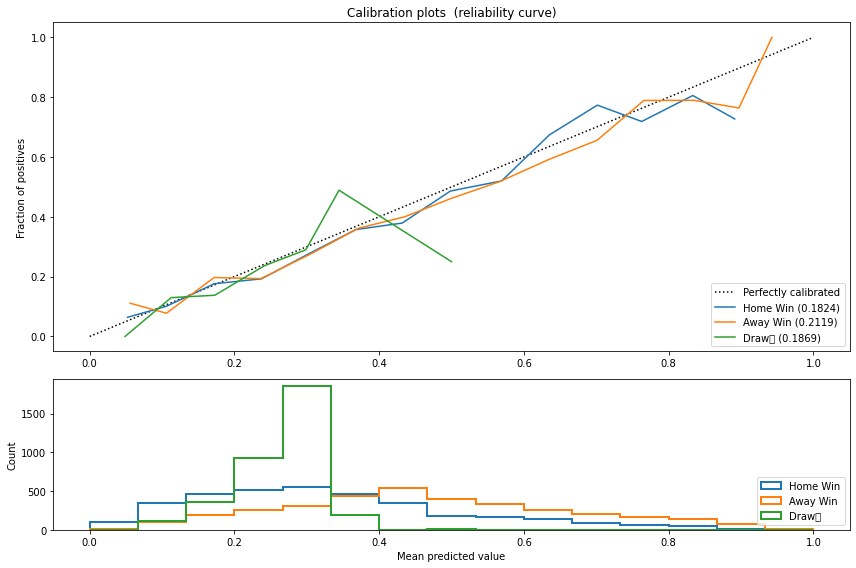

In [28]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\t Brier Loss: {:.4f}".format(
            name, brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

data = [
    (prob_df['home_win'], prob_df['home_win_prob'], 'Home Win'),
    (prob_df['away_win'], prob_df['away_win_prob'], 'Away Win'),
    (prob_df['draw'], prob_df['draw_prob'], 'Draw\t'),
]
cal_curve(data, 15)

That's interesting. The MLB baseball project had [0.2358 Brier Score](https://rdpharr.github.io/project_notes/baseball/benchmark/webscraping/brier/accuracy/calibration/2020/09/20/baseball_project.html). Lower is better in brier land, so this is 15-30% better. But baseball oddds were 60% accurate, these are 50%.

## Conclusion

52% accuracy and 0.18-0.21 Brier score is what we'll be shooting to beat with a machine learning model. I have no idea if that's doable. In the baseball model, there weren't the large gaps in casino odds. I may have to find a different source if that becomes a barrier.

This was only meant to give an idea of how well oddsmakers predict matches, but I already see some interesting features of the data. I'll leave you to explore further. I'd be especially interested in the profitability of predicting match draws, as well as any differences among the leagues - perhaps some are more competitive than others.

Remember - hit the buttons at the top to download and run this notebook yourself.

